In [14]:
# !pip install dgl

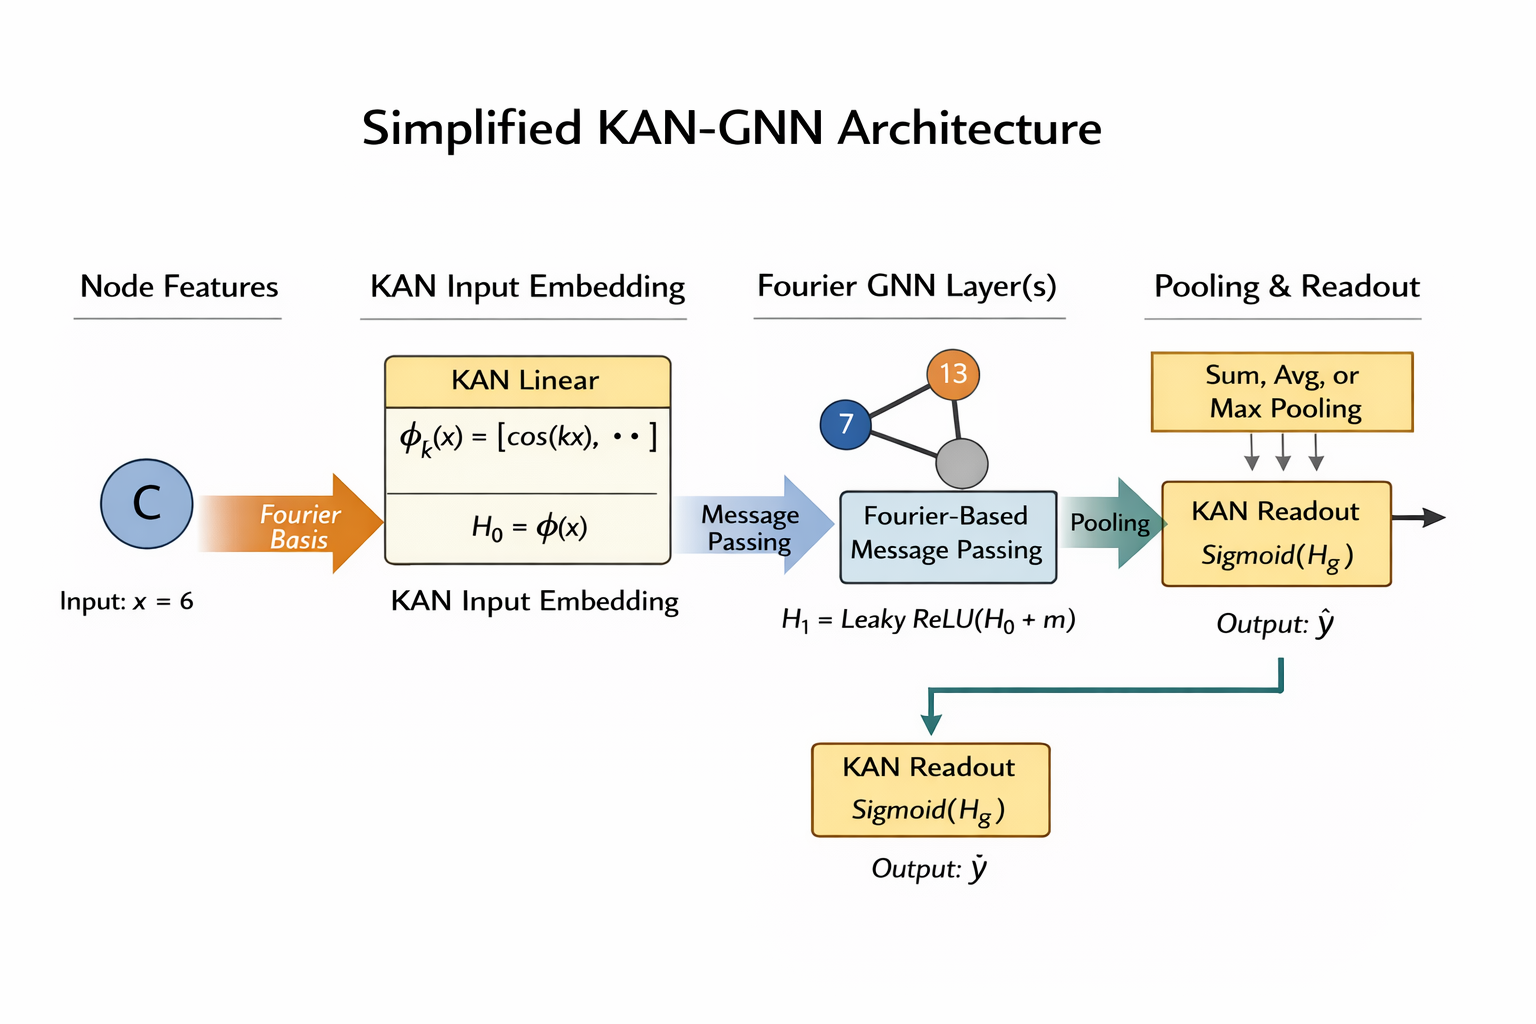

In [12]:
# !git clone --recurse-submodules https://github.com/dmlc/dgl.git

In [8]:
!pip install torchdata==0.7.1


2408.85s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [9]:
!pip install pydantic


2417.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [10]:

import torchdata


In [11]:
import torch
import dgl

print("Torch:", torch.__version__)
print("DGL:", dgl.__version__)
print("Backend:", dgl.backend.backend_name)


Torch: 2.1.2+cu121
DGL: 2.1.0
Backend: pytorch


In [12]:
import dgl.function as fn

In [13]:
from dgl.nn import SortPooling, WeightAndSum, GlobalAttentionPooling, Set2Set, SumPooling, AvgPooling, MaxPooling

In [18]:
import torch.nn as nn

In [15]:
import torch.functional as F

In [16]:
import numpy as np 

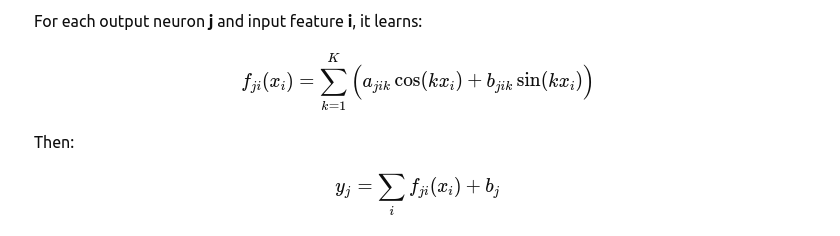

In [26]:
#################################################################################

# KAN linear Fourier node embedding

#################################################################################

In [21]:
class KAN_nonlinear(nn.Module):
    def __init__(self, in_feats, out_feats,grid_size,addbias=True):    #grid_size is number of Fourier modes (how many sine/cosine terms)
        super(KAN_nonlinear, self).__init__()
        self.in_feats = in_feats
        self.out_feats = out_feats
        self.reset_parameters() 
        self.grid_size=grid_size    
        self.addbias=addbias

        self.fourrier_weights = nn.Parameter(torch.randn(2,in_feats, out_feats, grid_size)/   # This is the 'Learnable Fourier Weights" defined as a basis function
                                             np.sqrt(in_feats) * np.sqrt(self.out_feats))     # 2 for sine and cosine as both are used
                                             
                                                            # The reason for deviding by sqrt is to normalize the weights to stabilize the training and avoid exploding gradients


        if addbias: 
            self.bias = nn.Parameter(torch.zeros(1,out_feats))         # This represents standard bias term added after the linear transformation



    def reset_parameters(self):                              # 
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

def forward(self,x):
        xshp = x.shape
        outshape = xshp[0:-1] + (self.out_feats,)
        x = x.view(-1, self.in_feats)
        k = torch.reshape(torch.arange(1, self.grid_size+1, device=x.device), (1, 1, 1, self.grid_size))
        xrshp = x.view(x.shape[0], 1, x.shape[1], 1)
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)

    
        c = torch.reshape(c, (1, x.shape[0], x.shape[1], self.grid_size))
        s = torch.reshape(s, (1, x.shape[0], x.shape[1], self.grid_size))
        y = torch.einsum("dbik,djik->bj", torch.concat([c, s], axis=0), self.fourier_weights)
        if self.addbias:
            y += self.bias
        y = y.view(outshape)
        return y

In [27]:
##########################################################################################

# Single Fourier message passing layer

##########################################################################################

In [42]:
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, in_feats, out_feats, grid_size, addbias=True):
        super().__init__()
        self.grid_size = grid_size
        self.addbias = addbias
        self.in_feats = in_feats
        self.out_feats = out_feats

        self.fourier_weights = nn.Parameter(torch.randn(2, out_feats, in_feats, grid_size) / 
                                          (np.sqrt(in_feats) * np.sqrt(grid_size)))
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(out_feats))



        def forward(self, g, x):
            with g.local_scope():
                 g.ndata['h'] = x
                 g.update_all(message_func=self.fourier_transform, reduce_func=fn.sum(msg='m', out='h'))   # Message passing step using Fourier transform defined below
                 
            if self.addbias:
                g.ndata['h'] += self.bias

            return g.ndata['h']
        



    def fourier_transform(self, edges):
        src_feat = edges.src['h']  # Take features from the source node of each edge.
        k = torch.reshape(torch.arange(1, self.gridsize + 1, device=src_feat.device), (1, 1, 1, self.gridsize))
        src_rshp = src_feat.view(src_feat.shape[0], 1, src_feat.shape[1], 1)
        cos_kx = torch.cos(k * src_rshp)
        sin_kx = torch.sin(k * src_rshp)
        cos_kx = cos_kx.view(1, src_feat.shape[0], src_feat.shape[1], self.gridsize)
        sin_kx = sin_kx.view(1, src_feat.shape[0], src_feat.shape[1], self.gridsize)
        m = torch.einsum("dbik,djik->bj", torch.cat([cos_kx, sin_kx], dim=0), self.fourier_weights)
        return {'m': m}   #DGL expects messages as a dictionary


In [36]:
##################################################################################################

# KAN GNN model    
 
##################################################################################################

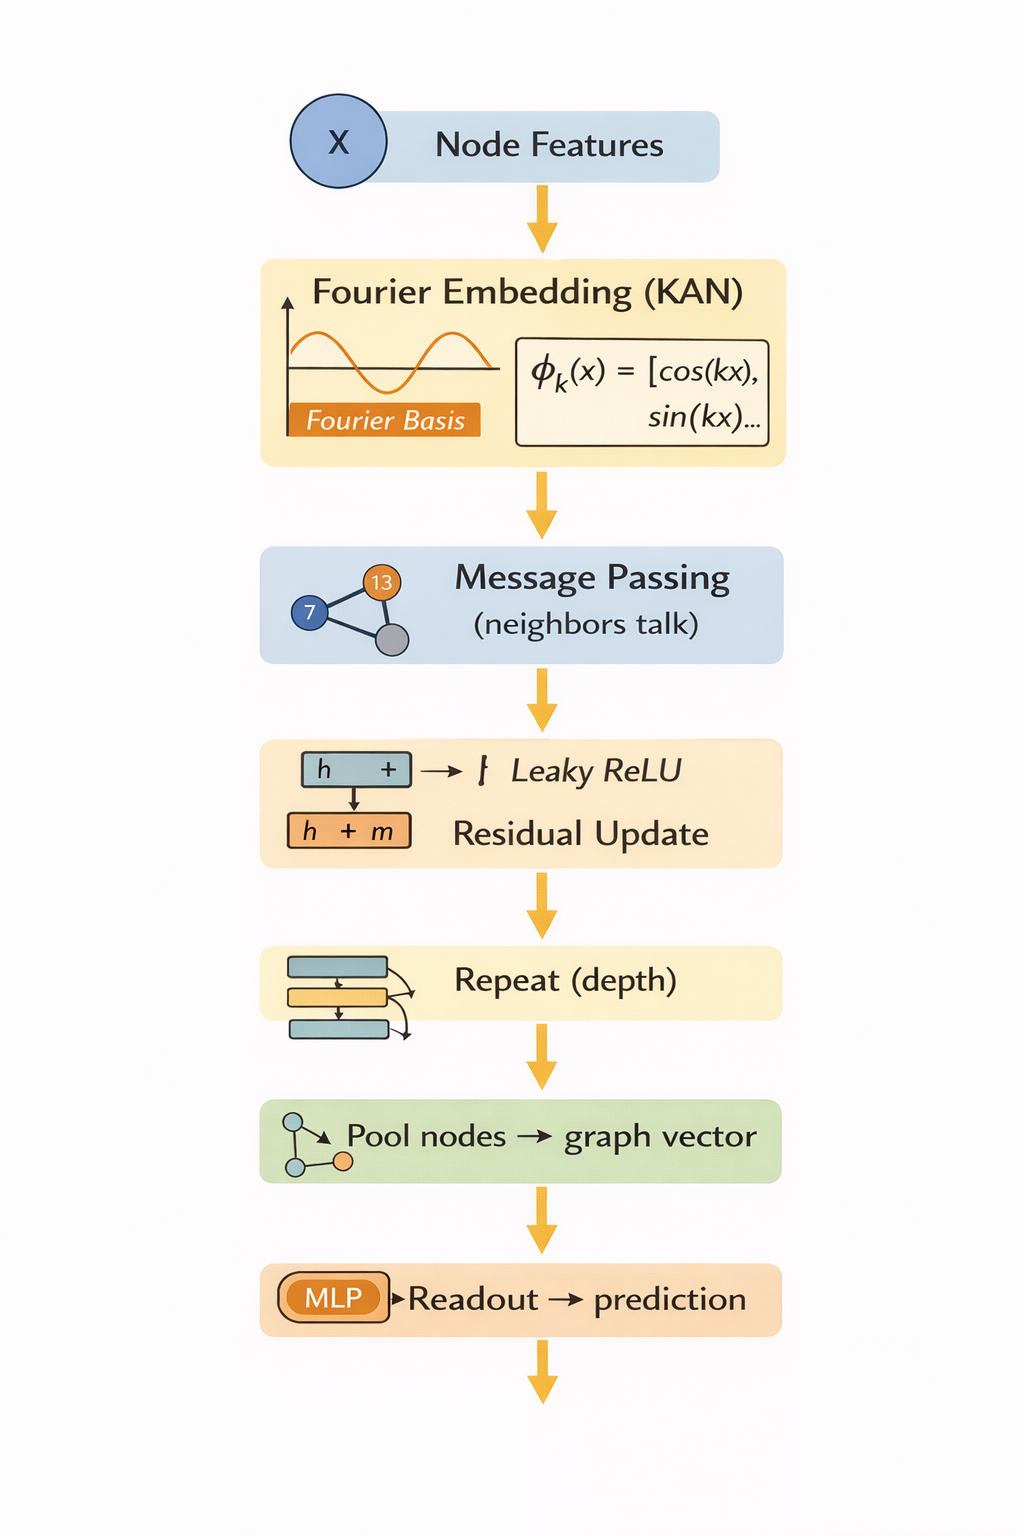

In [ ]:
class KA_GNN_Simple(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, grid_size, num_layers=2, pooling='sum', use_bias=True):    # This represents the pieces of the KAN GNN model
        super().__init__()
        self.pooling = pooling

        ### Input embedding
        self.kan_line = KAN_nonlinear(in_feats, hidden_feats, grid_size, addbias=use_bias)

        ### Message passing layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.layers.append(NaiveFourierKANLayer(hidden_feats, hidden_feats, grid_size, addbias=use_bias))#Each layer sends fourier transformed messages to neighbors and aggrsgates messages by summation 

        ### Output readout ( Graph to Output) # After pooling , graph does not exists anymore and it is turned into a "vector" 
        self.readout = nn.Sequential(
            KAN_nonlinear(hidden_feats, out_feats, 1, addbias=True),
            nn.Sigmoid()   # Final activation to ensure output is between 0 and 1
        )

    def forward(self, g, features):     # This represents how does the data flow through the model architectue 
        h = self.kan_line(features)
        for layer in self.layers:
            m = layer(g, h)          # Aggregegated messages from neighbors
            h = F.leaky_relu(h + m)  # residual update , introduces non-linearity and prevenst "dead neurons"

        # Pooling
        if self.pooling == 'sum':
            y = dgl.readout_nodes(g, 'h', op='sum')  # Sum pooling over all node features to get graph-level representation
        elif self.pooling == 'avg':
            y = dgl.readout_nodes(g, 'h', op='mean') # Average pooling over all node features
        elif self.pooling == 'max':
            y = dgl.readout_nodes(g, 'h', op='max')  # Max pooling over all node features
        else:
            raise ValueError("Unknown pooling type")

        out = self.readout(y)
        return out

#################################################################

# About the model itself , the parameters and the configurations:

#################################################################

Model design & architecture is based on the following arguments:

in_feat : Node feature size 
hidden_feat : internal embedding size 
out_feat : Output size 
grid_size : Number of Fourier Frequencies 
num_layers: Depth of message Passing 
pooling : How nodes mapps into graph 
use_bias : whether to add bias 